In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import choice

import scipy
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow
from keras.utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!ls "/content/gdrive/MyDrive/Colab Notebooks/Mask_Data"

Test_Data  Train_Data  Validation_Data


In [4]:
# Define the path to dataset
dataset_path = '/content/gdrive/MyDrive/Colab Notebooks/Mask_Data/Train_Data'

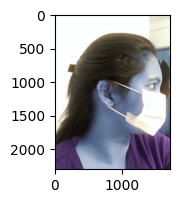

In [5]:
# Select a random image from the  train dataset

class_name = choice(['without_mask', 'with_mask'])
class_path = os.path.join(dataset_path, class_name)

image_name = choice(os.listdir(class_path))
image_path = os.path.join(class_path, image_name)

# Read and Display the random image
image = cv2.imread(image_path)
plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.show()

In [6]:
# Define the data generator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True)


# Define the data generator for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the data generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# Define the training, validation, and test data generators
train_generator = train_datagen.flow_from_directory(
    "/content/gdrive/MyDrive/Colab Notebooks/Mask_Data/Train_Data",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    classes=['without_mask', 'with_mask'])

val_generator = val_datagen.flow_from_directory(
    "/content/gdrive/MyDrive/Colab Notebooks/Mask_Data/Validation_Data",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    classes=['without_mask', 'with_mask'],
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    "/content/gdrive/MyDrive/Colab Notebooks/Mask_Data/Test_Data",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    classes=['without_mask', 'with_mask'],
    shuffle=False)


Found 1955 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [7]:
# Load the pre-trained VGG16 model with the weights of ImageNet
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in vgg16.layers[:-2]:
    layer.trainable = False

# Unfreeze the ONLY the last convolutional layer in the last convolutional block of the pre-trained model
for layer in vgg16.layers[-2:]:
    layer.trainable = True

# Add a new fully connected layer on top of the pre-trained model
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Create a new model that includes both the pre-trained model and the new layers
model = Model(inputs=vgg16.input, outputs=x)

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
# ModelCheckpoint is a popular callback in Keras that allows to save the model weights during training.
# This is useful because it allows to resume training if the process is interrupted,
# and it also allows you to select the best model based on some metric (e.g. validation accuracy) rather than just the final model.

# To use ModelCheckpoint, need to create an instance of the callback and pass it to the fit method


# Create a ModelCheckpoint callback that saves the best model after each epoch, based on validation accuracy
checkpoint = ModelCheckpoint(
      '/content/gdrive/MyDrive/Colab Notebooks/my_model.tf',
      monitor = 'val_accuracy',
      verbose = 0,
      save_best_only = True,
      save_weights_only = False,
      mode = "auto",
      save_freq="epoch",
      initial_value_threshold=None
      )

In [9]:
# Train the model using the fit() method
# The fit() method takes the training and validation data generators as inputs, along with other parameters.

# The fit() method returns a 'history' object that contains the training and validation loss and accuracy values for each epoch.
# We can use this object to plot the training and validation curves and evaluate the performance of the model.


history = model.fit(
    train_generator, # The training data generator
    steps_per_epoch=train_generator.samples // batch_size, # The number of steps (batches) per epoch
    validation_data=val_generator, # The validation data generator
    validation_steps=val_generator.samples // batch_size, # The number of steps (batches) per validation epoch
    epochs=20,    # The number of epochs to train the model for
    callbacks=[checkpoint])

# around 14 min in T4 GoogleColab

Epoch 1/20
61/61 [==============================] - 61s 732ms/step - loss: 0.4559 - accuracy: 0.9069 - val_loss: 0.0514 - val_accuracy: 0.9792
Epoch 2/20
61/61 [==============================] - 43s 713ms/step - loss: 0.0531 - accuracy: 0.9797 - val_loss: 0.0414 - val_accuracy: 0.9844
Epoch 3/20
61/61 [==============================] - 41s 665ms/step - loss: 0.0314 - accuracy: 0.9891 - val_loss: 0.0528 - val_accuracy: 0.9844
Epoch 4/20
61/61 [==============================] - 40s 663ms/step - loss: 0.0197 - accuracy: 0.9912 - val_loss: 0.0485 - val_accuracy: 0.9896
Epoch 5/20
61/61 [==============================] - 37s 607ms/step - loss: 0.0183 - accuracy: 0.9948 - val_loss: 0.0372 - val_accuracy: 0.9896
Epoch 6/20
61/61 [==============================] - 37s 601ms/step - loss: 0.0317 - accuracy: 0.9901 - val_loss: 0.2185 - val_accuracy: 0.9609
Epoch 7/20
61/61 [==============================] - 41s 680ms/step - loss: 0.0178 - accuracy: 0.9938 - val_loss: 0.0238 - val_accuracy: 0.9922

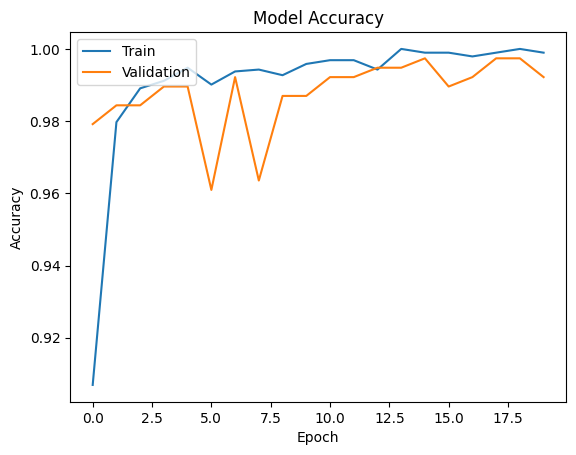

In [10]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

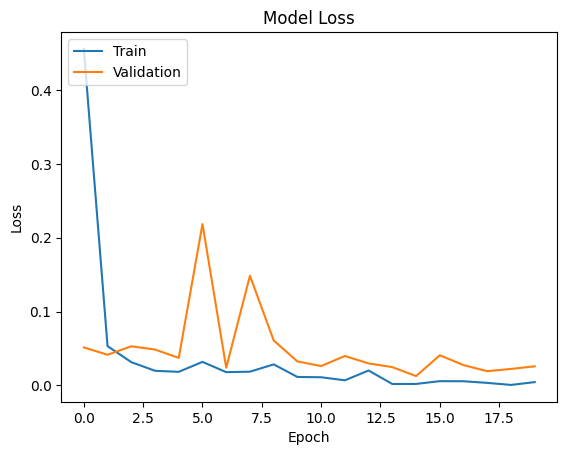

In [11]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
# Load the model saved by the checkpoint
top_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/my_model.tf')

In [13]:
# Generate predictions for the validation set
y_pred = top_model.predict(val_generator)
# Convert the predicted probabilities to binary labels
y_pred = y_pred > 0.5

# Get the true labels of the validation set
y_true = val_generator.classes
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred).astype(int)

# Print the confusion matrix with integer values
print('Confusion Matrix:')
print(conf_matrix)

13/13 [==============================] - 5s 422ms/step
Confusion Matrix:
[[198   2]
 [  2 198]]


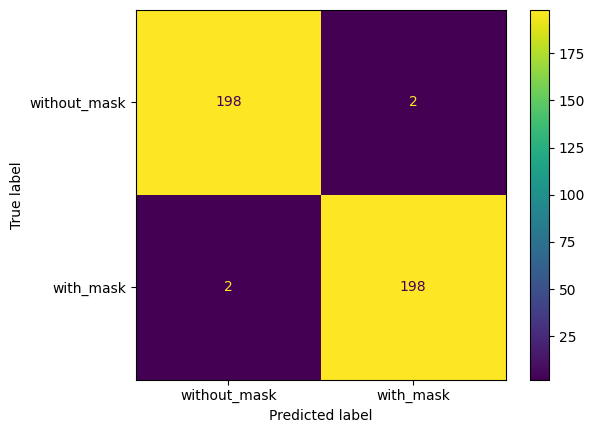

In [14]:
# Define the class labels
class_labels = ['without_mask', 'with_mask']
# Create the confusion matrix display
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)

# Plot the confusion matrix
cm_display.plot()
plt.show()

In [15]:
# Calculate the precision, recall, and F1-score
report = classification_report(y_true, y_pred, target_names=['without_mask', 'with_mask'])

# Print the report
print(report)

              precision    recall  f1-score   support

without_mask       0.99      0.99      0.99       200
   with_mask       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



In [16]:
!ls "/content/gdrive/MyDrive/Colab Notebooks/Mask_Data/Test_Data"

with_mask  without_mask


In [17]:
!ls "/content/gdrive/MyDrive/Colab Notebooks/Mask_Data/"

Test_Data  Train_Data  Validation_Data


In [18]:
def preprocess_image_to_test(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Resize the image while maintaining its aspect ratio
    h, w, _ = image.shape
    if h > w:
        ratio = 224 / h
    else:
        ratio = 224 / w
    resized_img = cv2.resize(image, (int(w * ratio), int(h * ratio)), interpolation=cv2.INTER_AREA)

    # Add padding to make the image 224x224
    h, w, _ = resized_img.shape
    pad_h = (224 - h) // 2
    pad_w = (224 - w) // 2
    padded_img = cv2.copyMakeBorder(resized_img, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_CONSTANT)

    # Preprocess the image
    image = np.expand_dims(padded_img, axis=0)
    image = image / 255.0

    # Resize the image to (224, 224, 3)
    image = cv2.resize(image[0], (224, 224), interpolation=cv2.INTER_AREA)
    image = np.expand_dims(image, axis=0)

    return image

In [19]:
# Load some images to test
test01 = preprocess_image_to_test('/content/gdrive/MyDrive/Colab Notebooks/Mask_Data/Test_Data/with_mask/01.jpg')
test02 = preprocess_image_to_test('/content/gdrive/MyDrive/Colab Notebooks/Mask_Data/Test_Data/with_mask/02.jpg')
test03 = preprocess_image_to_test('/content/gdrive/MyDrive/Colab Notebooks/Mask_Data/Test_Data/without_mask/03.jpg')
test04 = preprocess_image_to_test('/content/gdrive/MyDrive/Colab Notebooks/Mask_Data/Test_Data/without_mask/04.jpg')

In [20]:
test01.shape

(1, 224, 224, 3)

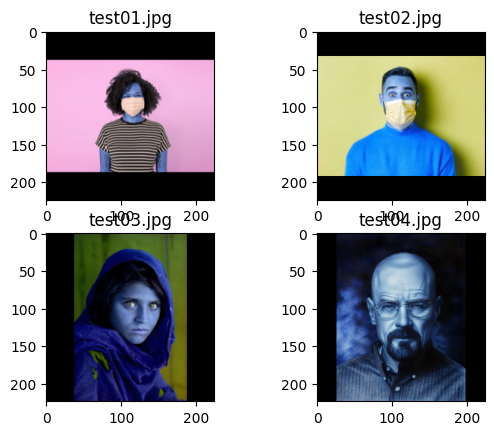

In [21]:
# Display the test images
plt.subplot(2, 2, 1)
plt.imshow(test01[0])
plt.title('test01.jpg')

plt.subplot(2, 2, 2)
plt.imshow(test02[0])
plt.title('test02.jpg')

plt.subplot(2, 2, 3)
plt.imshow(test03[0])
plt.title('test03.jpg')

plt.subplot(2, 2, 4)
plt.imshow(test04[0])
plt.title('test04.jpg')

plt.show()

In [22]:
# Make predictions
prediction01 = top_model.predict(test01)
prediction02 = top_model.predict(test02)
prediction03 = top_model.predict(test03)
prediction04 = top_model.predict(test04)

print()

# Print the predictions
if prediction01 < 0.5:
    print('The person in test01.jpg is not wearing a mask.')
else:
    print('The person in test01.jpg is wearing a mask.')

if prediction02 < 0.5:
    print('The person in test02.jpg is not wearing a mask.')
else:
    print('The person in test02.jpg is wearing a mask.')

if prediction03 < 0.5:
    print('The person in test03.jpg is not wearing a mask.')
else:
    print('The person in test03.jpg is wearing a mask.')

if prediction04 < 0.5:
    print('The person in test04.jpg is not wearing a mask.')
else:
    print('The person in test04.jpg is wearing a mask.')

1/1 [==============================] - 0s 76ms/step

The person in test01.jpg is wearing a mask.
The person in test02.jpg is wearing a mask.
The person in test03.jpg is not wearing a mask.
The person in test04.jpg is not wearing a mask.
